# Recency, Frequency, Monetary Segmentation with Python

What is RFM?
RFM is a behavioural segmentation model determined by 3 important features:
1. Recency — number of days since the last purchase
2. Frequency — number of transactions made over a given period
3. Monetary — amount spent over a given period of time

RFM segmentation allows marketers to cater communications to different clusters of consumers that better fit their particular behaviour generating higher response rates and increased customer LTV. 

#### Import Revelant Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime as dt


import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 


#### Data Load & Cleaning

In [2]:
df = pd.read_csv('data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})

In [3]:
df.shape

(541909, 8)

In [4]:
# change the InvoiceDate column type from object to an actual DateTime
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

In [5]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [6]:
# check the number of missing CustomerID's, since this data cannot be imputed we will have to drop these rows
print('Count of missing CustomerIDs:',df['CustomerID'].isnull().sum(axis=0))
df.dropna(inplace=True)

Count of missing CustomerIDs: 135080


In [7]:
# check to see if there are any duplicated rows, if so delete these as well
print('Count of duplicated rows:', df.duplicated().sum())
df.drop_duplicates(inplace=True)

Count of duplicated rows: 5225


In [8]:
# Find the max and min transaction dates
print('Max Transaction Date:',df['InvoiceDate'].max(),', Min Transaction Date:',df['InvoiceDate'].min())

Max Transaction Date: 2011-12-09 12:50:00 , Min Transaction Date: 2010-12-01 08:26:00


In [9]:
# New Row and Column Count
df.shape

(401604, 8)

In [10]:
# look at the number of cancelled orders
# exclude all cancelled orders from the analysis

print('Number of Orders Cancelled:', df[df['InvoiceNo'].str.contains('C')]['InvoiceNo'].count()) 
df = df[~df['InvoiceNo'].str.contains('C')]

Number of Orders Cancelled: 8872


In [11]:
# drop rows with a unit price = 0
df.drop(df[df['UnitPrice']==0].index, inplace=True)

#### Exploratory Data Analysis

In [12]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [13]:
df.describe()

,Quantity,UnitPrice
count,392692.000000,392692.000000
mean,13.119702,3.125914
std,180.492832,22.241836
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [14]:
# Unique Counts of Some Features
print('Unique Count of Customers:',df['CustomerID'].nunique())
print('Unique Count of Items:',df['StockCode'].nunique())
print('Unique Count of Countries:',df['Country'].nunique())
print('Unique Count of Orders:', df['InvoiceNo'].nunique())

Unique Count of Customers: 4338
Unique Count of Items: 3665
Unique Count of Countries: 37
Unique Count of Orders: 18532


In [15]:
# Number of orders per customer
df1 = df[['CustomerID','InvoiceNo']].drop_duplicates()
txns = df1.groupby('CustomerID', as_index=False)['InvoiceNo'].count()
txns.rename(columns={'InvoiceNo':'Invoice Count'},inplace=True)
txns.head()

,CustomerID,Invoice Count
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


Text(0.5, 1.0, 'Distribution of the Order Count of a Customer')

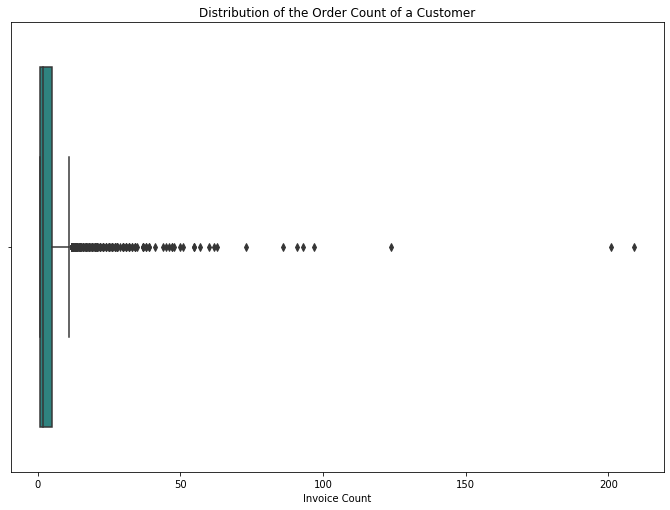

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(txns['Invoice Count'],palette='viridis')
plt.title('Distribution of the Order Count of a Customer')

In [19]:
# Number of items per transaction (non unique)
items = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
items.rename(columns={'InvoiceDate':'Number of Products'},inplace=True)
items.head()

,CustomerID,InvoiceNo,Number of Products
0,12346,541431,1
1,12347,537626,31
2,12347,542237,29
3,12347,549222,24
4,12347,556201,18


Text(0.5, 1.0, 'Distribution of Number of Products in a Order')

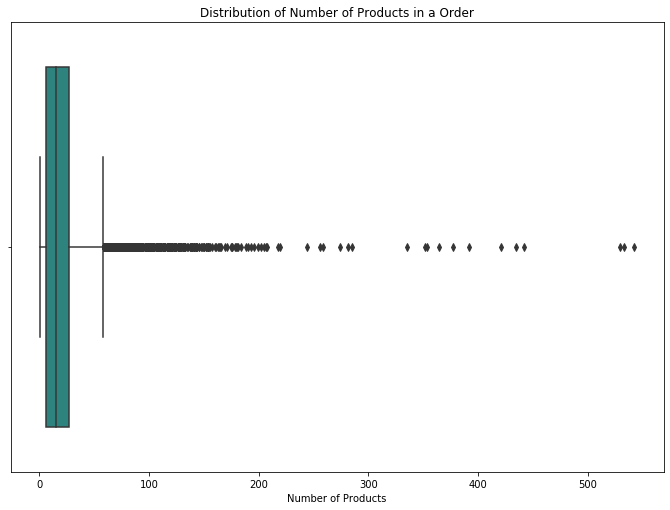

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(items['Number of Products'],palette='viridis')
plt.title('Distribution of Number of Products in a Order')

In [21]:
# get some info about the countries people are from

df1 = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
df1.reset_index(drop = False, inplace=True)

country= df1['Country'].value_counts()
country.head()

United Kingdom    16646
Germany             457
France              389
EIRE                260
Belgium              98
Name: Country, dtype: int64

In [22]:
country.index

Index(['United Kingdom', 'Germany', 'France', 'EIRE', 'Belgium', 'Netherlands',
       'Spain', 'Australia', 'Portugal', 'Switzerland', 'Finland', 'Italy',
       'Norway', 'Sweden', 'Channel Islands', 'Japan', 'Poland', 'Denmark',
       'Austria', 'Cyprus', 'Unspecified', 'Singapore', 'Iceland', 'Canada',
       'Greece', 'Malta', 'USA', 'Israel', 'Lithuania', 'European Community',
       'United Arab Emirates', 'Czech Republic', 'Bahrain', 'Saudi Arabia',
       'Brazil', 'Lebanon', 'RSA'],
      dtype='object')

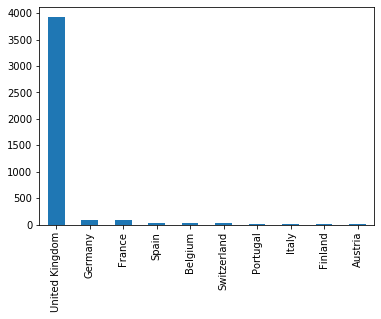

In [23]:
# number of customers in a country
df2 = df1.loc[:,('CustomerID','Country')]
df2.drop_duplicates(inplace=True)
df2['Country'].value_counts()[:10].plot(kind='bar')

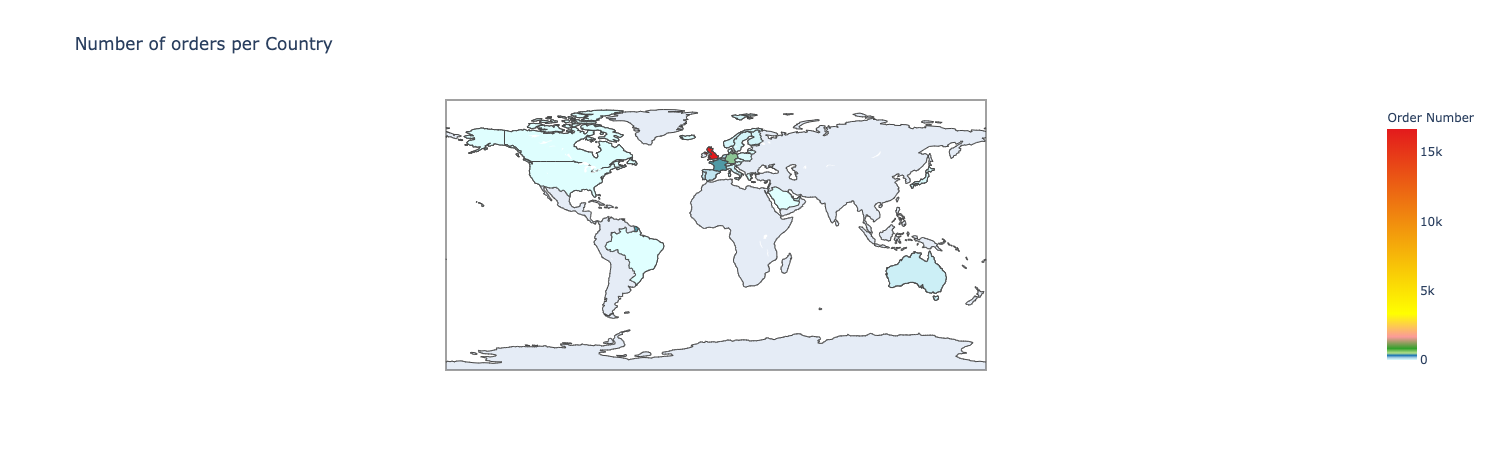

In [24]:
# Chloropleth Map to Show frequency per Country
data = dict(type = 'choropleth',
            locations = country.index,
            locationmode = 'country names',
            z = country,
            colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']], 
            text= country.index,
            colorbar = {'title':'Order Number'})
layout = dict(title='Number of orders per Country')
geo = dict(showframe = True, projection={'type':'mercator'})

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap, validate=False)

#### Assign Recency, Frequency and Monetary variables to each row

1. Group data by Customer
2. Determine the highest value customers by total spend
3. Find out the transaction dates and frequency of transactions

In [25]:
data = df.loc[:,['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
data['TotalSales'] = df['Quantity'] * df['UnitPrice']
data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalSales
0,17850,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850,2010-12-01 08:26:00,536365,6,3.39,20.34


In [26]:
data['InvoiceDate'].min(), data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [27]:
present = data['InvoiceDate'].max() + timedelta(days=1)
present

Timestamp('2011-12-10 12:50:00')

For Recency, Calculate the number of days between present date and date of last purchase each customer.\
For Frequency, Calculate the number of orders for each customer.\
For Monetary, Calculate sum of purchase price for each customer.

In [28]:
rfm = data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (present - date.max()).days,
                                      'InvoiceNo': lambda num: len(num),
                                      'TotalSales': lambda price: price.sum()
                                     })

In [29]:
rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSales':'Monetary'}, inplace = True)

In [30]:
rfm.dtypes

Recency        int64
Frequency      int64
Monetary     float64
dtype: object

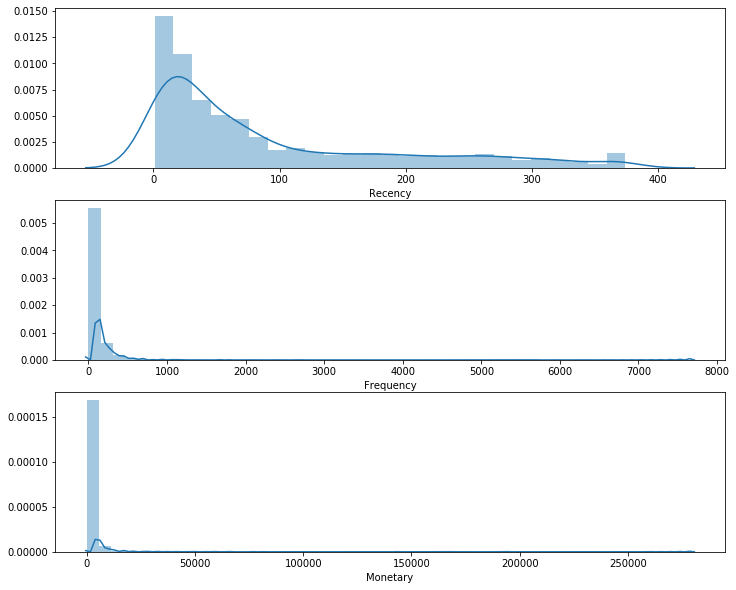

In [31]:
plt.figure(figsize=(12,10))
plt.subplot(3,1,1); sns.distplot(rfm['Recency'])
plt.subplot(3,1,2); sns.distplot(rfm['Frequency'])
plt.subplot(3,1,3); sns.distplot(rfm['Monetary'])

Compute the Quantile of RFM Values, customers with the lowest recency, highest frequency and monetary amounts are considered top customers\
using qcut() - Quantile based discretization function will bin the data based on sample quantiles

customers who purchased recently, are frequent buyers and spend a lot are assigned score of 555 – Recency(R) – 5, Frequency(F) – 5, Monetary(M) – 5\
we can now group customers together based on their score and identify

In [32]:
r_labels = range(5,0,-1)
f_labels = range(1,6)
m_labels = range (1,6)
rfm['r_quartile'] = pd.qcut(rfm['Recency'], 5, labels = r_labels)
rfm['f_quartile'] = pd.qcut(rfm['Frequency'], 5, labels = f_labels)
rfm['m_quartile'] = pd.qcut(rfm['Monetary'], 5, m_labels)

In [33]:
rfm['RFM_Segment'] = rfm['r_quartile'].astype(str) + rfm['f_quartile'].astype(str) + rfm['m_quartile'].astype(str)

In [34]:
rfm['RFM_Score'] = rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)

In [35]:
rfm.groupby('RFM_Score').agg({'Recency':'mean','Frequency':'mean','Monetary':['mean','count']}).head()

Recency  Frequency    Monetary      
                 mean       mean        mean count
RFM_Score                                         
3.0        278.557196   7.033210  138.579815   271
4.0        203.426923  11.246154  199.571808   260
5.0        182.603261  16.307065  295.459946   368
6.0        126.088312  19.763636  370.394704   385
7.0        102.749347  26.185379  901.194833   383

In [36]:
# Assign labels based on the total score using quantiles

labels = ['Tier5','Tier4','Tier3','Tier2','Tier1']
rfm['RFM_Level'] = pd.qcut(rfm['RFM_Score'], q=5, labels = labels)

In [37]:
rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,5,115,7.0,Tier4
12347,2,182,4310.00,5,5,5,555,15.0,Tier1
12348,75,31,1797.24,2,3,4,234,9.0,Tier3
12349,19,73,1757.55,4,4,4,444,12.0,Tier2
12350,310,17,334.40,1,2,2,122,5.0,Tier5


K-Means Clustering

Key steps
1. Data pre-processing
2. Choosing a number of clusters
3. Running k-means clustering on pre-processed data
4. Analyzing average RFM values of each cluster

In [38]:
rfm[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,90.523744,2048.688081
std,100.014169,225.506968,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,306.482500
50%,51.000000,41.000000,668.570000
75%,142.000000,98.000000,1660.597500
max,374.000000,7676.000000,280206.020000


need to scale the data since the data is right skewed, using logarithicmic transformation changes the data to be normally distributed

In [39]:
#Unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

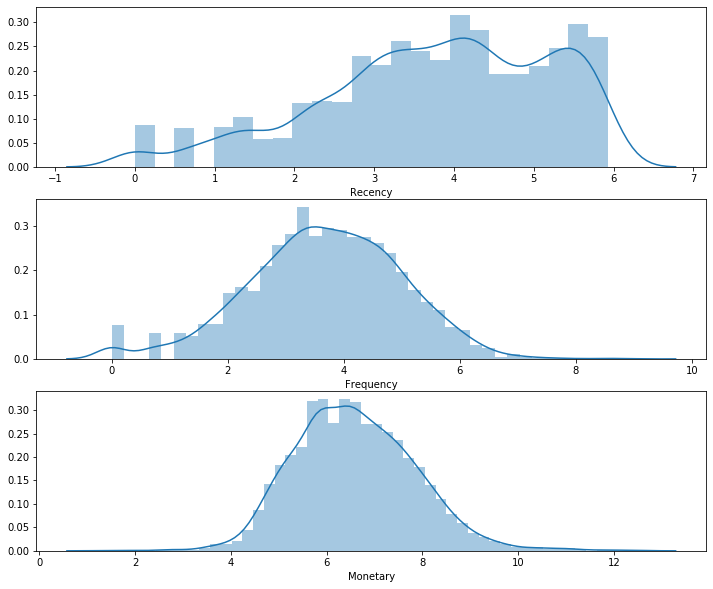

In [40]:
plt.figure(figsize=(12,10))
plt.subplot(3,1,1); sns.distplot(rfm_log['Recency'])
plt.subplot(3,1,2); sns.distplot(rfm_log['Frequency'])
plt.subplot(3,1,3); sns.distplot(rfm_log['Monetary'])

In [56]:
# scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics 
from scipy.spatial.distance import cdist 
from yellowbrick.cluster import KElbowVisualizer

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled

array([[ 1.40998159, -2.77997064,  3.70023933],
       [-2.14657818,  1.16036535,  1.41349442],
       [ 0.38364809, -0.17983348,  0.71994094],
       ...,
       [-1.1788923 , -0.89839206, -1.11262551],
       [-1.66273524,  2.20299461,  0.82219054],
       [-0.00454336,  0.43650655,  0.73737886]])

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

We now define the following:-

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.\
Inertia: It is the sum of squared distances of samples to their closest cluster center.
We iterate the values of k from 1 to 9 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

Methods to define the number of clusters
1. Visual methods - elbow criterion
2. Mathematical methods - silhouette coefficient
3. Experimentation and interpretation

Elbow criterion method
1. Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center
2. Identify an "elbow" in the plot
3. Elbow - a point representing an "optimal" number of clusters

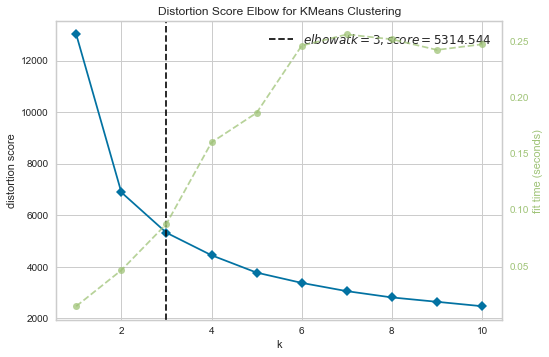

In [59]:
# the Elbow method

distortions = []
inertias = []
mapping1 = []
mapping2 = []
K = range(1,11)

for k in K:
    kmeanModel = KMeans(n_clusters= k, random_state=101)
    kmeanModel.fit(rfm_scaled)
    inertias.append(kmeanModel.inertia_) 
    
visualizer = KElbowVisualizer(kmeanModel, k=(1,11))

visualizer.fit(rfm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure    
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

# plt.figure(figsize=(12,8))  
# plt.plot(K, inertias, 'bx-')
# plt.xlabel('Number of Clusters, k')
# plt.ylabel('Inertia:=, Sum of Squared Distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [60]:
# Using k = 3
kmeanModel = KMeans(n_clusters= 3, random_state=101)
kmeanModel.fit(rfm_scaled)

# Assign the clusters to rfm data
rfm['K_Cluster'] = kmeanModel.labels_
rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerID,,,,,,,,,,
12346,326,1,77183.60,1,1,5,115,7.0,Tier4,2
12347,2,182,4310.00,5,5,5,555,15.0,Tier1,0
12348,75,31,1797.24,2,3,4,234,9.0,Tier3,2
12349,19,73,1757.55,4,4,4,444,12.0,Tier2,2
12350,310,17,334.40,1,2,2,122,5.0,Tier5,1


In [44]:
rfm.groupby('K_Cluster').agg({'Recency':'mean','Frequency':'mean','Monetary':['mean','count']})

Recency   Frequency     Monetary      
                 mean        mean         mean count
K_Cluster                                           
0           12.963158  260.800000  6584.545895   950
1          169.929733   14.964216   293.339213  1537
2           69.111831   65.873582  1178.297095  1851

Visualize the clusters

In [ ]:
# heatmap with RFM
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")

# a snake plot with K-Means
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()